In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import statsmodels.api as sm 

from itertools import combinations, product, permutations
from __future__ import division
from collections import Counter
from scipy.stats.mstats import mquantiles
from scipy.stats import norm, expon, poisson, binom
from scipy.misc import comb
from IPython.display import Math
from networkx.readwrite import json_graph 
from geopy.geocoders import GeoNames
from geopy.geocoders import GoogleV3

%matplotlib inline

In [2]:
def golden_figsize(height):
    """
    Assuming height dimension is the shorter one, the width should be:
    (1 + 5**0.5)/2
    
    This function thus returns the (width, height) tuple which is
    computed to be in a golden ratio.
    """
    width = height * (1 + 5**0.5) / 2
    return (width, height)

In [3]:
G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')

In [22]:
geocoder = GoogleV3(timeout=5)

In [23]:
G.nodes()[15]

'A/Texas/44301765/2009'

In [31]:
# Nichola has coded them as wild/domestic and avian/mammalian. I will add these into the graph. 

# Load the data
df = pd.read_csv('Country-Species_to_be_Coded_by_Nichola.csv', index_col=0)

# Make it into a dicitonary where each entry is (country, species):habitat/setting
ecotype_map = dict()

for row, data in df.iterrows():
    country = data['Country']
    species = data['Species']
    ecotype = data['Habitat/setting']

    ecotype_map[(country, species)] = ecotype

    
def get_country_location_pairs(G):
    search_terms = set()
    node_search_terms = dict()
    for n, d in G.nodes(data=True):
        country = d['country']
        specific_region = n.split('/')[-3]
        
        cleaned_country = country.replace('_', ' ')
        
        if specific_region != cleaned_country:
            search_term = '{0}_{1}'.format(cleaned_country, specific_region)
    
        else:
            search_term = cleaned_country
        
        search_terms.add(search_term)
        node_search_terms[n] = search_term.replace('_', ' ')
    return search_terms, node_search_terms

countries_to_search, node_search_terms = get_country_location_pairs(G)
countries_to_search
node_search_terms

{'A/mallard/Interior Alaska/6MP0160AR1/2006': 'USA Interior Alaska',
 'A/swine/Hong Kong/NS970/2012': 'Hong Kong',
 'A/New York/132/2002': 'USA New York',
 'A/guinea fowl/New Jersey/7290-19/1994': 'USA New Jersey',
 'A/California/VRDL88/2009': 'USA California',
 'A/tufted duck/PT/13771/2006': 'Portugal PT',
 'A/Boston/YGA_00093/2012': 'USA Boston',
 'A/village chicken/Kyaing Tong/2433/2007': 'Myanmar Kyaing Tong',
 'A/HaNoi/Q163/2007': 'Viet Nam HaNoi',
 'A/baikal teal/Korea/Donglim3/2014': 'South Korea Korea',
 'A/northern pintail/Interior Alaska/9BM6248R0/2009': 'USA Interior Alaska',
 'A/greater white-fronted goose/California/44358-089/2007': 'USA California',
 'A/Duck/Nanchang/2-0485/2000': 'China Nanchang',
 'A/Houston/1H/2009': 'USA Houston',
 'A/Texas/44301765/2009': 'USA Texas',
 'A/Russia/61/2009': 'Russia',
 'A/swine/Minnesota/SG1236/2005': 'USA Minnesota',
 'A/mallard/Wisconsin/986/1982': 'USA Wisconsin',
 'A/California/NHRC0008/2005': 'USA California',
 'A/mallard/Ohio/99/1

In [28]:
# Find a GPS coordinate for each
geodata = []
for search_term in countries_to_search:
    new_search_term = search_term.replace('_', ' ')
    loc = geocoder.geocode(new_search_term)
    if loc is None:
        loc = geocoder.geocode(cleaned_country)
    lat = loc.latitude
    lon = loc.longitude
    data = (search_term, u'{0}'.format(loc), lon, lat)
    geodata.append(data)
    print(data)

('Canada', u'Canada', -106.346771, 56.130366)
('Australia New South Wales', u'New South Wales, Australia', 151.2052868, -33.864174)
('France Reunion', u'R\xe9union, 29680 Roscoff, France', -3.994667999999999, 48.702056)
('USA Florida', u'Florida, USA', -81.5157535, 27.6648274)
('USA Santa Clara', u'Santa Clara, CA, USA', -121.9552356, 37.3541079)
('Peru Piura', u'Piura, Peru', -80.633333, -5.2)
('Indonesia Banten', u'Banten, Republic of Indonesia', 106.0640179, -6.4058172)
('South Korea KU', u'National Assembly of South Korea, Uisadang-daero, Yeoeuido-dong, Yeongdeungpo-gu, Seoul, South Korea', 126.9191163, 37.5318933)
('China Guangzhou', u'Guangzhou, Guangdong, China', 113.264385, 23.12911)
('USA Minneapolis', u'Minneapolis, MN, USA', -93.2650108, 44.977753)
('Viet Nam TayNguyen', u'T\xe2y Nguy\xean, \u0110\u0103k Ha, \u0110\u1eafk Glong, \u0110\u0103k N\xf4ng, Vietnam', 107.7850886, 12.083802)
('Sweden Umea', u'Ume\xe5, Sweden', 20.2630354, 63.8258471)
('USA South Dakota', u'South Da

In [36]:
geodf = pd.DataFrame(geodata)
geodf.columns = ['Search Term', "Returned Location", 'Longitude', 'Latitude']
geodf.to_csv('Country Geocoding.csv', encoding='utf-8')



In [9]:
# ecotype_map
# Add the ecotype into each node.
for n, d in G.nodes(data=True):
    country = d['country']
    species = d['host_species']
    if '/' in species:
        species = species.split('/')[0]
    if 'null' in species:
        species = 'Unknown'
        
        
    cleaned_country = country.replace('_', ' ')
    specific_region = n.split('/')[-3]
    if specific_region != cleaned_country:
        search_term = '{0} {1}'.format(cleaned_country, specific_region)
    else:
        search_term = cleaned_country
    print(search_term)
    location = geocoder.geocode(search_term)
    print('  ' + str(location))
    if location is None:
        location = geocoder.geocode(cleaned_country)
    lat = location.latitude
    lon = location.longitude
    
    

    
    G.node[n]['ecotype'] = ecotype_map[(country, species)]
    G.node[n]['latitude'] = lat
    G.node[n]['longitude'] = lon

USA Interior Alaska
  US Department of the Interior, 3601 C Street # 1100, Anchorage, AK 99503, USA
USA Memphis
  Memphis, TN, USA
Hong Kong
  Hong Kong
USA New Jersey
  New Jersey, USA
USA California
  California, USA
Portugal PT
  Portugal
USA Boston
  Boston, MA, USA
Myanmar Kyaing Tong
  Kyaing Tong Street, Yangon, Republic of the Union of Myanmar
Peru
  Peru
South Korea Korea
  South Korea
USA Interior Alaska
  US Department of the Interior, 3601 C Street # 1100, Anchorage, AK 99503, USA
USA California


GeocoderQuotaExceeded: The given key has gone over the requests limit in the 24 hour period or has submitted too many requests in too short a period of time.

In [6]:
# Identify the reassortants.

# Add reassortant status for each node.
for n, d in G.nodes(data=True):
    in_edge_types = set([d['edge_type'] for sc, sk, d in G.in_edges(n, data=True)])
    if 'reassortant' in in_edge_types:
        G.node[n]['reassortant'] = True
    elif 'full_complement' in in_edge_types:
        G.node[n]['reassortant'] = False
    else:
        G.node[n]['reassortant'] = False
        
def is_reassortant(G, node):
    return G.node[node]['reassortant']

reassortant_viruses = []
for n, d in G.nodes(data=True):
    if is_reassortant(G, n):
        reassortant_viruses.append(n)
        
print(len(reassortant_viruses))

2017


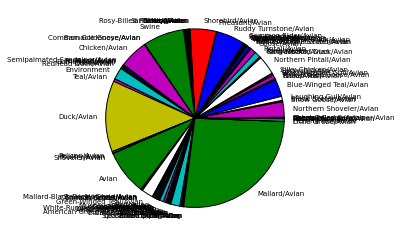

In [5]:
reassortant_hosts = []
for virus in reassortant_viruses:
    reassortant_hosts.append(G.node[virus]['host_species'])
    
plt.pie(Counter(reassortant_hosts).values(), labels=Counter(reassortant_hosts).keys())
plt.axes().set_aspect('equal')
plt.show()

In [6]:
condensed_reassortant_hosts = []
for host in reassortant_hosts:
    if '/' in host:
        host = host.split('/')[1]
        if host == 'null':
            host = 'Unknown'
        condensed_reassortant_hosts.append(host)
    else:
        if host == 'null':
            host = 'Unknown'
        condensed_reassortant_hosts.append(host)


In [8]:
def get_host_group(G, node):
    host = G.node[node]['host_species']
    if 'Human' in host or 'human' in host:
        host = 'Human'
    elif 'Avian' in host or 'avian' in host:
        host = 'Avian'
    elif 'Unknown' in host or 'unknown' in host:
        host = 'Unknown'
    elif 'null' in host or 'Null' in host:
        host = 'Unknown'
    elif 'Swine' in host or 'swine' in host:
        host = 'Swine'
    else:
        host = 'Mammal'
        
    return host

def correct_host_group_ecotype(G, node):
    host = get_host_group(G.node[node]['host_species'])
    
    if host == 'Avian':
        if G.node[node]['ecotype'] == 'Domestic':
            host = 'Avian Domestic'
        else:
            host = 'Avian Wild'
            
    return host

In [8]:
# Get total representation of viruses
all_hosts = []
for n, d in G.nodes(data=True):
    all_hosts.append(correct_host_group_ecotype(G, n))

In [9]:
def counter_proportions(counter):
    total = sum(counter.values())
    
    proportions = dict()
    for key, value in counter.items():
        proportions[key] = float(value)/float(total)
        
    return proportions

def categorical_counter_xlabels(counter):
    idxs = dict()
    
    for i, key in enumerate(counter.keys()):
        idxs[key] = i
        
    return idxs

In [10]:
# all_hosts

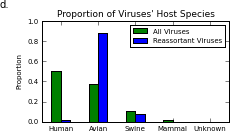

In [11]:
# Plot the proportion of hosts for reassortant viruses
counts = Counter(condensed_reassortant_hosts)
props = counter_proportions(counts)
# xpos = categorical_counter_xlabels(counts)

reassortant_proportions = pd.DataFrame(props.values(), index=props.keys()).sort(0, ascending=False)
reassortant_proportions.columns = ['Reassortant Viruses']

counts = Counter(all_hosts)
props = counter_proportions(counts)
all_proportions = pd.DataFrame(props.values(), index=props.keys()).sort(0, ascending=False)
all_proportions.columns = ['All Viruses']

joined_proportions = all_proportions.join(reassortant_proportions)
joined_proportions.plot(kind='bar', grid=False, figsize=golden_figsize(2), color=['green', 'blue'])

# Plotting parameters.
ax = plt.gca()
# plt.xlabel('Host Species')
ax.set_ylabel('Proportion', fontsize=7)
ax.set_title("Proportion of Viruses' Host Species", fontsize=9)
plt.ylim(0, 1)
plt.legend(fontsize=7)
xlabels = ax.get_xticklabels()
plt.setp(xlabels, rotation=0, ha='center', fontsize=7) 
ylabels = ax.get_yticklabels()
plt.setp(ylabels, fontsize=7)

ax.annotate('d.', xy=(0,1), ha='left', va='top', xycoords='figure fraction')

plt.subplots_adjust(bottom=0.2, right=0.95, left=0.15)
plt.savefig('Proportion of Reassortant Viruses Host Species.pdf')

In [12]:
# Perform host species permutation test to assess what the distribution of reassortant viruses would be under null.

host_shuffledG = G.copy()

proportions = []

for i in range(1000):
    reassortant_species = dict()
    from random import shuffle
    hosts = [get_host_group(G, n) for n in G.nodes()]
    shuffle(hosts)

    # Add in condensed host
    for i, n in enumerate(host_shuffledG.nodes()):
        host_shuffledG.node[n]['host_group'] = hosts[i]

    for n, d in host_shuffledG.nodes(data=True):
        if is_reassortant(G, n):
            if d['host_group'] not in reassortant_species.keys():
                reassortant_species[d['host_group']] = 1
            else:
                reassortant_species[d['host_group']] += 1
                
    proportions.append(reassortant_species)

In [13]:
pd.DataFrame(proportions)

,Avian,Human,Mammal,Swine,Unknown
0,711,1056,34,212,4
1,775,987,30,222,3
2,764,1003,44,204,2
3,739,1002,51,222,3
4,734,1034,31,213,5
5,755,1020,41,197,4
6,733,1015,39,225,5
7,770,1015,39,192,1
8,762,998,37,219,1
9,765,1002,42,203,5


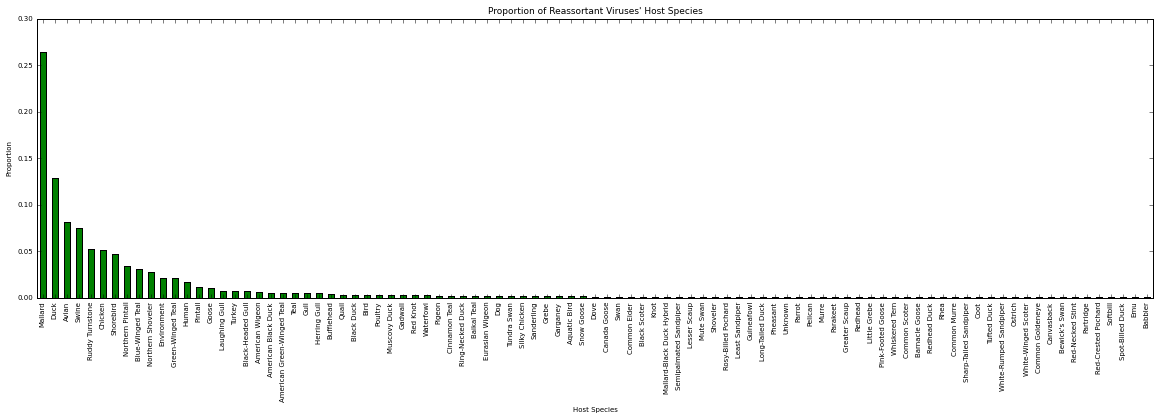

In [14]:
# Create a detailed version of the counter, which includes the exact species represented.
detailed_hosts = []
for virus in reassortant_viruses:
    host = G.node[virus]['host_species']
    if '/' in host:
        host = host.split('/')[0]
    if 'null' in host:
        host = 'Unknown'
    detailed_hosts.append(host)

counts = Counter(detailed_hosts)
props = counter_proportions(counts)
xpos = categorical_counter_xlabels(counts)

pd.DataFrame(props.values(), index=props.keys()).sort(0, ascending=False).plot(kind='bar', figsize=(16,5), grid=False, legend=False, color='green')
fig = plt.gcf()
fig.set_size_inches(20,5) 
plt.xlabel('Host Species')
plt.ylabel('Proportion')
plt.title("Proportion of Reassortant Viruses' Host Species")
plt.savefig('Proportion of Reassortant Viruses Host Species (Detailed).pdf', bbox_inches='tight')

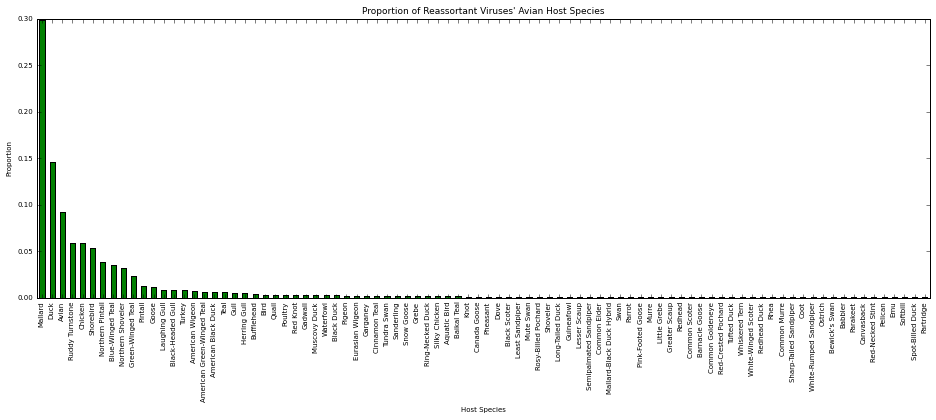

In [15]:
# Create a detailed version of the counter, which includes the exact AVIAN only species represented.
detailed_avians = []
for virus in reassortant_viruses:
    host = G.node[virus]['host_species']
    if 'Avian' in host or 'avian' in host:
        if '/' in host:
            host = host.split('/')[0]
        detailed_avians.append(host)

counts = Counter(detailed_avians)
props = counter_proportions(counts)
xpos = categorical_counter_xlabels(counts)

pd.DataFrame(props.values(), index=props.keys()).sort(0, ascending=False).plot(kind='bar', figsize=(16,5), grid=False, legend=False, color='green')
fig = plt.gcf()
fig.set_size_inches(16,5) 
plt.xlabel('Host Species')
plt.ylabel('Proportion')
plt.title("Proportion of Reassortant Viruses' Avian Host Species")
plt.savefig('Proportion of Reassortant Viruses Host Species (Avian Only).pdf', bbox_inches='tight')

# Sampling Size Biases Subtype Connectivity?

Does sampling size for a particular subtype bias the subtype's connectivity with other subtypes via reassortment?

In [16]:
subtype_counts = Counter()
for n, d in G.nodes(data=True):
    subtype = d['subtype']
    subtype_counts[subtype] += 1
    
subtype_counts

Counter({'H1N1': 5565, 'H3N2': 4349, 'H5N1': 794, 'H3N8': 714, 'H4N6': 680, 'H1N2': 446, 'H9N2': 357, 'H6N2': 300, 'H10N7': 291, 'H5N2': 259, 'H7N3': 223, 'H11N9': 223, 'H6N1': 188, 'H7N2': 179, 'H2N3': 152, 'H6N6': 141, 'H6N8': 117, 'H4N8': 95, 'H3N6': 90, 'H7N9': 84, 'H7N7': 83, 'H4N2': 67, 'H12N5': 67, 'H11N2': 66, 'H8N4': 65, 'Mixed': 51, 'H7N1': 46, 'H5N8': 43, 'H5N5': 36, 'H5N3': 35, 'H2N2': 34, 'H1N9': 34, 'H10N1': 32, 'H3N1': 32, 'H6N5': 29, 'H2N9': 28, 'H10N3': 26, 'H2N1': 26, 'H1N3': 26, 'H10N4': 24, 'H16N3': 24, 'H11N1': 23, 'H7N6': 20, 'H4N9': 20, 'H2N7': 19, 'H2N5': 18, 'H10N8': 16, 'H11N3': 15, 'H10N6': 14, 'H10N9': 13, 'H6N3': 13, 'H7N4': 13, 'H13N6': 13, 'H3N3': 12, 'H11N8': 11, 'H2N8': 10, 'H4N3': 10, 'H1N8': 10, 'H9N5': 10, 'H13N8': 10, 'H10N5': 9, 'H3N5': 9, 'H9N1': 9, 'H9N9': 9, 'H10N2': 8, 'H4N1': 8, 'H7N8': 8, 'H5N9': 7, 'H1N7': 7, 'H5N7': 6, 'H3N9': 6, 'H6N4': 6, 'H4N5': 5, 'H6N9': 5, 'H11N6': 5, 'H12N4': 5, 'H13N9': 5, 'H4N7': 4, 'H6N7': 4, 'H1N6': 4, 'H1N4': 4,

In [17]:
centralities = pd.read_csv('Subtype Reassortment Centralities.csv', index_col=0)
centralities = dict(zip(centralities['Subtype'], centralities['Degree Centrality']))

In [18]:
def ols_fit_predict(xs, ys):

    est = sm.OLS(ys, xs) 
    est = est.fit()
    print(est.summary())

    # Create the best line of fit data for plotting
    x_prime = np.linspace(min(xs), max(xs), 100)[:,np.newaxis]
    x_prime = sm.add_constant(x_prime)
    y_hat = est.predict(x_prime[:,1]) 
    
    rsquared = '{0:.2f}'.format(est.rsquared)
    
    return x_prime, y_hat, rsquared

In [19]:
# Plot params
titlefs = 9 #title fontsize
axisfs = 7 #axis fontsize
figsize = (2.5, 2.5) #figure size in inches

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     22.79
Date:                Wed, 18 Mar 2015   Prob (F-statistic):           5.70e-06
Time:                        18:07:37   Log-Likelihood:                -857.20
No. Observations:                 109   AIC:                             1716.
Df Residuals:                     108   BIC:                             1719.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          1117.3135    234.026      4.774      0.0

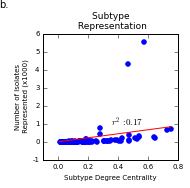

In [20]:
# Code to make scatterplot of subtype_counts vs centrality
xs = [] # centralities
ys = [] # counts in the dataset

for subtype, count in subtype_counts.items():
    xs.append(centralities[subtype])
    ys.append(count)
    
# Perform OLS regression
x_prime, y_hat, rsquared = ols_fit_predict(xs, ys)

# Plot the scatterplot and OLS
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.scatter(xs, ys, color='blue')
ax.plot(x_prime[:,1],y_hat, 'r')

ax.annotate(r'$r^2: {0}$'.format(rsquared), xy=(0.5, 0.3), xycoords='axes fraction', ha='left', va='center', fontsize=9)
ax.annotate(r'b.', xy=(0,1), xycoords='figure fraction', va='top')

# Plot parameters
ax.set_xlabel('Subtype Degree Centrality', fontsize=axisfs)
ax.set_ylabel('Number of Isolates \n Represented (x1000)', fontsize=axisfs)
ax.set_yticklabels(np.arange(-1, 7, 1))
ax.set_xticks(np.arange(0, 0.9, 0.2))
ax.set_title('Subtype \n Representation', fontsize=titlefs)
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.85)
plt.savefig('Subtype Representation vs. Subtype Connectivity.pdf')

# Save the data as a CSV file
csv_data = pd.DataFrame(xs, ys).reset_index()
csv_data.columns = ['Degree Centrality', 'Num Samples']
csv_data.to_csv('Subtype Representation vs. Subtype Connectivity.csv')

# Reassortment Host Range and Connectivity

One of the hypotheses I have is that that the inter-subtype degree centrality is related to the host range of the virus. To do this, I will plot a scatterplot of # of hosts represented against the degree centrality, for each subtype, with the radius of the dot proportional to the square root of the number of isolates represented.

In [21]:
subtype_hosts = dict()
subtype_counts = Counter()
for n, d in G.nodes(data=True):
    subtype = d['subtype']
    host = d['host_species']
    if host == 'mixed':
        host = 'Mixed'
    if host == 'null':
        host = 'Unknown'
    
    if subtype not in subtype_hosts.keys():
        subtype_hosts[subtype] = set()
        
    subtype_counts[subtype] += 1
    subtype_hosts[subtype].add(host)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     449.7
Date:                Wed, 18 Mar 2015   Prob (F-statistic):           2.69e-40
Time:                        18:07:38   Log-Likelihood:                -342.86
No. Observations:                 109   AIC:                             687.7
Df Residuals:                     108   BIC:                             690.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            44.3010      2.089     21.206      0.0

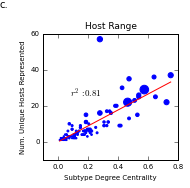

In [22]:
# Code to make bubble plot.
xs = []
ys = []
ss = []
dot_labels = []
subtypes = []

# Precisely specify the xs, ys, and sizes of the dots.
for subtype, host_set in subtype_hosts.items():
    subtypes.append(subtype)
    xs.append(centralities[subtype])
    ys.append(len(subtype_hosts[subtype]))
    ss.append(math.sqrt(subtype_counts[subtype]))
    if centralities[subtype] > 0.4 or len(subtype_hosts[subtype]) > 25:
        dot_labels.append(subtype)
    else:
        dot_labels.append('')

x_prime, y_hat, rsquared = ols_fit_predict(xs, ys)

# Plot scatterplot
fig = plt.figure(figsize=(2.5,2.5))
ax = fig.add_subplot(111)
ax.scatter(xs, ys, s=ss, color='blue')
ax.plot(x_prime[:,1], y_hat, 'r')

# Additional plotting parameters
ax.set_xlabel('Subtype Degree Centrality', fontsize=axisfs)
ax.set_ylabel('Num. Unique Hosts Represented', fontsize=axisfs)
ax.set_title('Host Range', fontsize=titlefs)
ax.annotate(r'$r^2: {0}$'.format(rsquared), xy=(0.2, 0.5), xycoords='axes fraction', fontsize=9)
ax.annotate(r'c.', xy=(0,1), xycoords='figure fraction', va='top', ha='left')
ax.set_yticks(np.arange(0, 61, 20))
ax.set_xticks(np.arange(0, 0.9, 0.2))


plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.85)
plt.savefig('Host Range vs. Degree Centrality.pdf')

# Finally, make a dataframe of the data to accompany the plot.
data = {'subtypes':subtypes,
        'centralities':xs,
        'num_unique_hosts':ys,
        'num_isolates':[i**2 for i in ss]}
pd.DataFrame(data).to_csv('Host Range vs. Degree Centrality.csv')

# Reassortment Geographic Range and Connectivity

Similar to the question above: Is there a relationship between the number of unique countries in which each subtype has been found?

In [23]:
subtype_countries = dict()
for n, d in G.nodes(data=True):
    subtype = d['subtype']
    country = d['country']
    
    if subtype not in subtype_countries.keys():
        subtype_countries[subtype] = set()
        
    subtype_countries[subtype].add(country)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     133.6
Date:                Wed, 18 Mar 2015   Prob (F-statistic):           1.35e-20
Time:                        18:07:39   Log-Likelihood:                -350.43
No. Observations:                 109   AIC:                             702.9
Df Residuals:                     108   BIC:                             705.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            25.8812      2.239     11.558      0.0

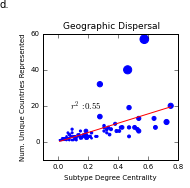

In [24]:
# Code to make bubble plot.
xs = []
ys = []
ss = []
dot_labels = []
subtypes = []

for subtype, host_set in subtype_hosts.items():
    subtypes.append(subtype)
    xs.append(centralities[subtype])
    ys.append(len(subtype_countries[subtype]))
    ss.append(math.sqrt(subtype_counts[subtype])) # Ensure that radius proportional to sqrt of counts.
    if centralities[subtype] > 0.2 and len(subtype_countries[subtype]) > 10:
        dot_labels.append(subtype)
    else:
        dot_labels.append('')

x_prime, y_hat, rsquared = ols_fit_predict(xs, ys)

# Plot the scatterplot
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.scatter(xs, ys, s=ss, color='blue')
ax.plot(x_prime[:,1], y_hat, 'r')

ax.set_xlabel('Subtype Degree Centrality', fontsize=axisfs)
ax.set_ylabel('Num. Unique Countries Represented', fontsize=axisfs)
ax.set_title('Geographic Dispersal', fontsize=titlefs)
# ax.text(-0.05, -6, 'Size of bubble proportional to number of isolates', ha='left')
ax.annotate(r'$r^2: {0}$'.format(rsquared), xy=(0.2, 0.4), xycoords='axes fraction', fontsize=9)
ax.set_yticks(np.arange(0, 61, 20))
ax.set_xticks(np.arange(0, 0.9, 0.2))
ax.annotate(r'd.', xy=(0,1), xycoords='figure fraction', va='top', ha='left')

plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.85)
plt.savefig('Geographic Dispersal vs. Degree Centrality.pdf')

# Finally, make a dataframe of the data to accompany the plot.
data = {'subtypes':subtypes,
        'centralities':xs,
        'num_unique_countries':ys,
        'num_isolates':[i**2 for i in ss]}
pd.DataFrame(data).to_csv('Geographic Dispersal vs. Degree Centrality.csv')

# Summary

The geographic dispersal and host range both have a correlation with the degree centrality score. I interpret this as such: The geographic dispersal and host range probably have an impact on the subtype's status as a "hub" subtype. 

Using OLS regression, I have found that the sampling size is poorly correlated with the subtype degree centrality, and should not be biasing the data, while host range is the most correlated with subtype connectivity, followed by geographic dispersal. 